# Apple and Orange CycleGan

In [1]:
import itertools
import zipfile, requests, io
import torchvision
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from utils.data.AppleOrangeDataset import *
from models.cycleGAN import *
from tqdm import tqdm
from collections import deque


In [2]:
if not os.path.exists('data/apple2orange'):
    response = requests.get('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange')
    zip = zipfile.ZipFile(io.BytesIO(response.content))
    zip.extractall('data')


In [3]:
input_shape = (3, 128, 128)
n_res_blocks = 9


In [4]:
cuda = lambda x: x.cuda() if t.cuda.is_available() else x
gen_ao = cuda(GenResNet(input_shape[0], n_res_blocks))
gen_oa = cuda(GenResNet(input_shape[0], n_res_blocks))
critic_a = cuda(Critic(input_shape))
critic_o = cuda(Critic(input_shape))


In [5]:
gen_ao.apply(norm)
gen_oa.apply(norm)
critic_a.apply(norm)
critic_o.apply(norm);


In [6]:
lr = .0002
b1, b2 = .5, .999
g_opt = t.optim.Adam(itertools.chain(gen_ao.parameters(), gen_oa.parameters()), lr=lr, betas=(b1, b2))
ca_opt = t.optim.Adam(critic_a.parameters(), lr=lr, betas=(b1, b2))
co_opt = t.optim.Adam(critic_o.parameters(), lr=lr, betas=(b1, b2))


In [7]:
epochs = 200
decay_epoch = epochs / 2
lr_step = lambda i: 1 - max(0, (i - decay_epoch) / (epochs - decay_epoch))
g_opt_lr_sch = LambdaLR(g_opt, lr_lambda=lr_step)
ca_opt_lr_sch = LambdaLR(ca_opt, lr_lambda=lr_step)
co_opt_lr_sch = LambdaLR(co_opt, lr_lambda=lr_step)


In [8]:
# resize original 286 to 143, then crop to 128, and expand train data variety by simple horiz flip
tfms = [transforms.Resize(143, Image.BICUBIC),
        transforms.RandomCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

train_bs, val_bs = 1, 2
train_dl = DataLoader(AppleOrangeDataset(tfms=tfms), batch_size=train_bs, shuffle=True)
val_dl = DataLoader(AppleOrangeDataset(tfms=tfms, train=False), batch_size=val_bs, shuffle=True)


In [9]:
device = t.device('cuda') if t.cuda.is_available() else 'cpu'
to_device = lambda x: x.to(device) if t.cuda.is_available() else x

gen_a_cache = deque(maxlen=50)
gen_o_cache = deque(maxlen=50)

mse_loss = t.nn.MSELoss()
l1_loss = t.nn.L1Loss()


  0%|          | 0/200 [00:00<?, ?it/s]

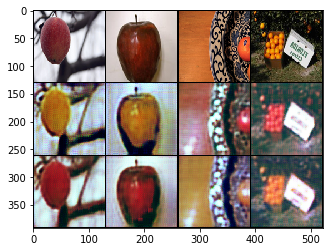

  4%|▍         | 9/200 [38:38<13:26:44, 253.43s/it]

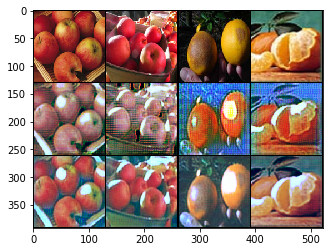

  9%|▉         | 18/200 [1:16:09<12:38:40, 250.11s/it]

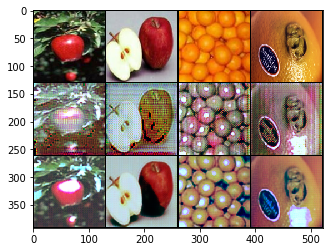

 14%|█▎        | 27/200 [1:54:37<12:23:42, 257.93s/it]

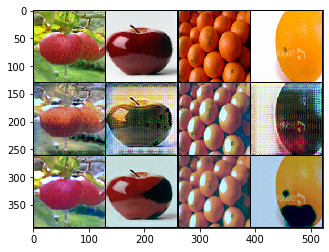

 18%|█▊        | 36/200 [2:31:23<11:10:50, 245.43s/it]

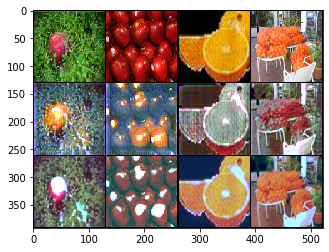

 22%|██▎       | 45/200 [3:08:05<10:32:00, 244.65s/it]

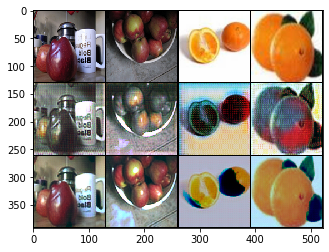

 27%|██▋       | 54/200 [3:44:46<9:55:05, 244.56s/it] 

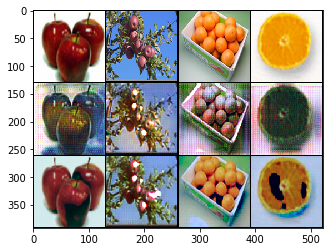

 32%|███▏      | 63/200 [4:21:27<9:18:16, 244.50s/it]

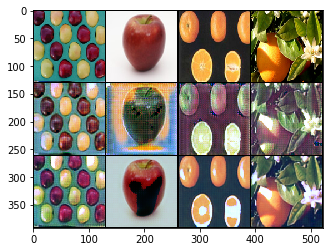

 36%|███▌      | 72/200 [4:58:08<8:41:46, 244.59s/it]

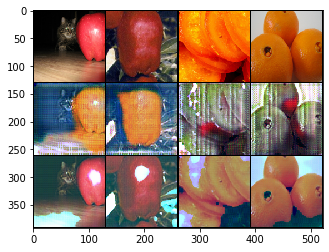

 40%|████      | 81/200 [5:34:49<8:04:57, 244.52s/it]

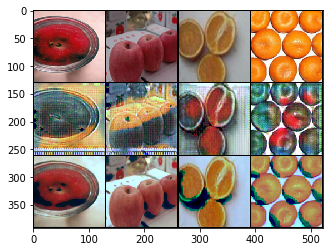

 45%|████▌     | 90/200 [6:11:25<7:26:49, 243.72s/it]

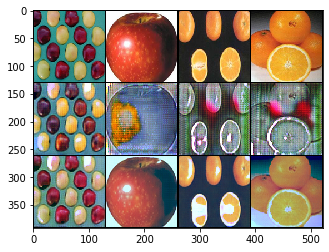

 50%|████▉     | 99/200 [6:47:58<6:50:12, 243.69s/it]

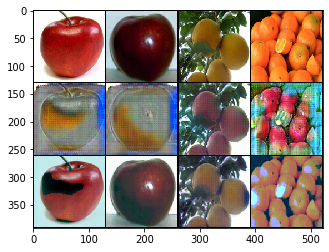

 54%|█████▍    | 108/200 [7:24:31<6:13:31, 243.60s/it]

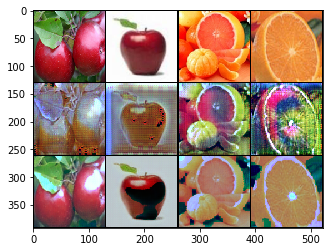

 58%|█████▊    | 117/200 [8:01:02<5:36:46, 243.45s/it]

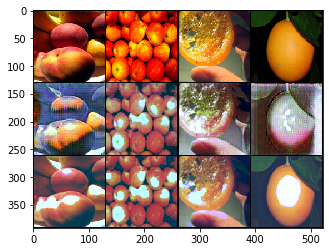

 63%|██████▎   | 126/200 [8:37:35<5:00:21, 243.53s/it]

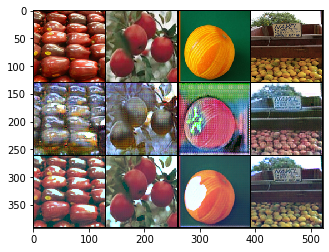

 68%|██████▊   | 135/200 [9:14:06<4:23:47, 243.49s/it]

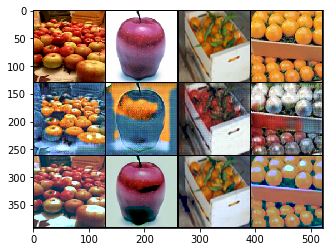

 72%|███████▏  | 144/200 [9:50:39<3:47:23, 243.64s/it]

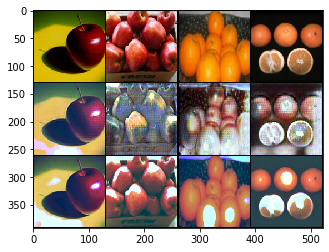

 76%|███████▋  | 153/200 [10:27:11<3:10:45, 243.53s/it]

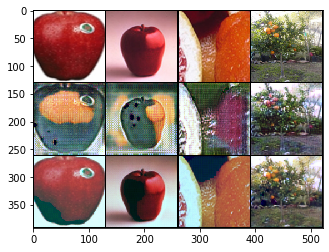

 81%|████████  | 162/200 [11:03:43<2:34:17, 243.61s/it]

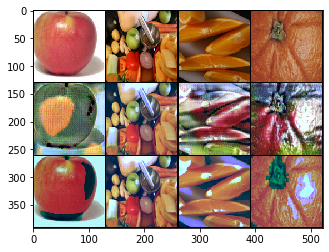

 86%|████████▌ | 171/200 [11:40:15<1:57:43, 243.56s/it]

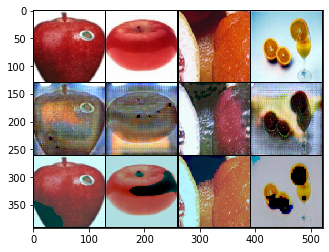

 90%|█████████ | 180/200 [12:16:47<1:21:10, 243.53s/it]

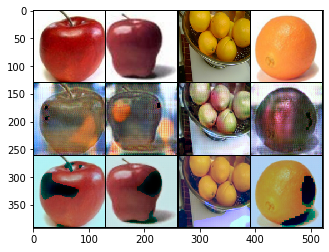

 94%|█████████▍| 189/200 [12:53:20<44:39, 243.57s/it]  

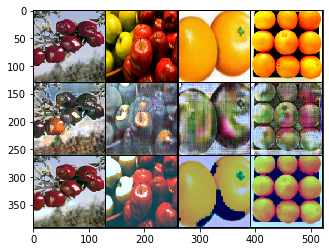

 99%|█████████▉| 198/200 [13:29:53<08:07, 243.68s/it]

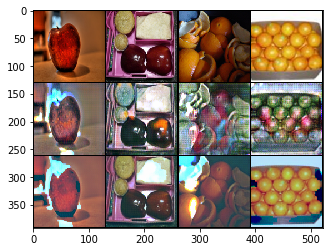

100%|██████████| 200/200 [13:38:01<00:00, 245.41s/it]


In [10]:
for epoch in tqdm(range(epochs)):
    for i, e in enumerate(train_dl):

        real_a = e['a'].to(device)
        real_o = e['o'].to(device)
        real = t.ones(real_a.shape[0], *critic_a.out_shape).to(device)

        # train generators
        g_opt.zero_grad()
        oa = gen_oa(real_a)
        ao = gen_ao(real_o)

        # identity loss - is gen_xy(y) = y and vice versa?
        id_a_loss = l1_loss(oa, real_a)
        id_o_loss = l1_loss(ao, real_o)
        id_loss = (id_a_loss + id_o_loss) / 2

        # validity loss - does critic think gen img is real?
        gen_o = gen_ao(real_a)
        gen_a = gen_oa(real_o)

        gan_ao_loss = mse_loss(critic_o(gen_o), real)
        gan_oa_loss = mse_loss(critic_a(gen_a), real)
        gan_loss = (gan_ao_loss + gan_oa_loss) / 2

        # Cycle Reconstruction loss - can we get same x from gen_yx(gen_xy(x)) and vice versa?
        recon_a = gen_oa(gen_o)
        recon_o = gen_ao(gen_a)

        cycle_a_loss = l1_loss(recon_a, real_a)
        cycle_o_loss = l1_loss(recon_o, real_o)
        cycle_loss = (cycle_a_loss + cycle_o_loss) / 2

        # full gen loss
        cyc_lambda, id_lambda = 10, 5
        g_loss = gan_loss + cyc_lambda * cycle_loss + id_lambda * id_loss

        g_loss.backward()
        g_opt.step()

        #  train critic a
        fake = t.zeros(real_o.shape[0], *critic_a.out_shape).to(device)
        ca_opt.zero_grad()

        real_loss = mse_loss(critic_a(real_a), real)
        gen_a_cache.extend(gen_a)
        fake_a = t.stack(random.sample(gen_a_cache, min(len(gen_a_cache), len(gen_a))))
        fake_loss = mse_loss(critic_a(fake_a.detach()), fake)

        ca_loss = (real_loss + fake_loss) / 2
        ca_loss.backward()
        ca_opt.step()

        #  train critic o
        co_opt.zero_grad()

        real_loss = mse_loss(critic_o(real_o), real)
        gen_o_cache.extend(gen_o)
        fake_o = t.stack(random.sample(gen_o_cache, min(len(gen_o_cache), len(gen_o))))
        fake_loss = mse_loss(critic_o(fake_o.detach()), fake)

        co_loss = (real_loss + fake_loss) / 2
        co_loss.backward()
        co_opt.step()

        # plot samples from val dl
    if epoch % 9 == 0:
        with t.no_grad():
            a, o = [e.to(device) for e in next(iter(val_dl)).values()]
            gen_a = gen_oa(o)
            gen_o = gen_ao(a)
            id_a = gen_oa(a)
            id_o = gen_ao(o)
        imgs = t.cat((a, o, gen_o, gen_a, id_a, id_o))
        grid_img = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
        plt.imshow(grid_img.permute(1, 2, 0).detach().cpu())
        plt.show()

    g_opt_lr_sch.step()
    ca_opt_lr_sch.step()
    co_opt_lr_sch.step()


### As we train more, we show signs of overfitting the training set.
### It just so happens that, there are other colors to pickup from the fruit images that are associated with fruits, such as green as you will soon see.  The dataset isn't that big, plus we are only doing a horizontal flip augmentation to make more variety. Maybe you can try adding more data or augment using different methods to get better results. 

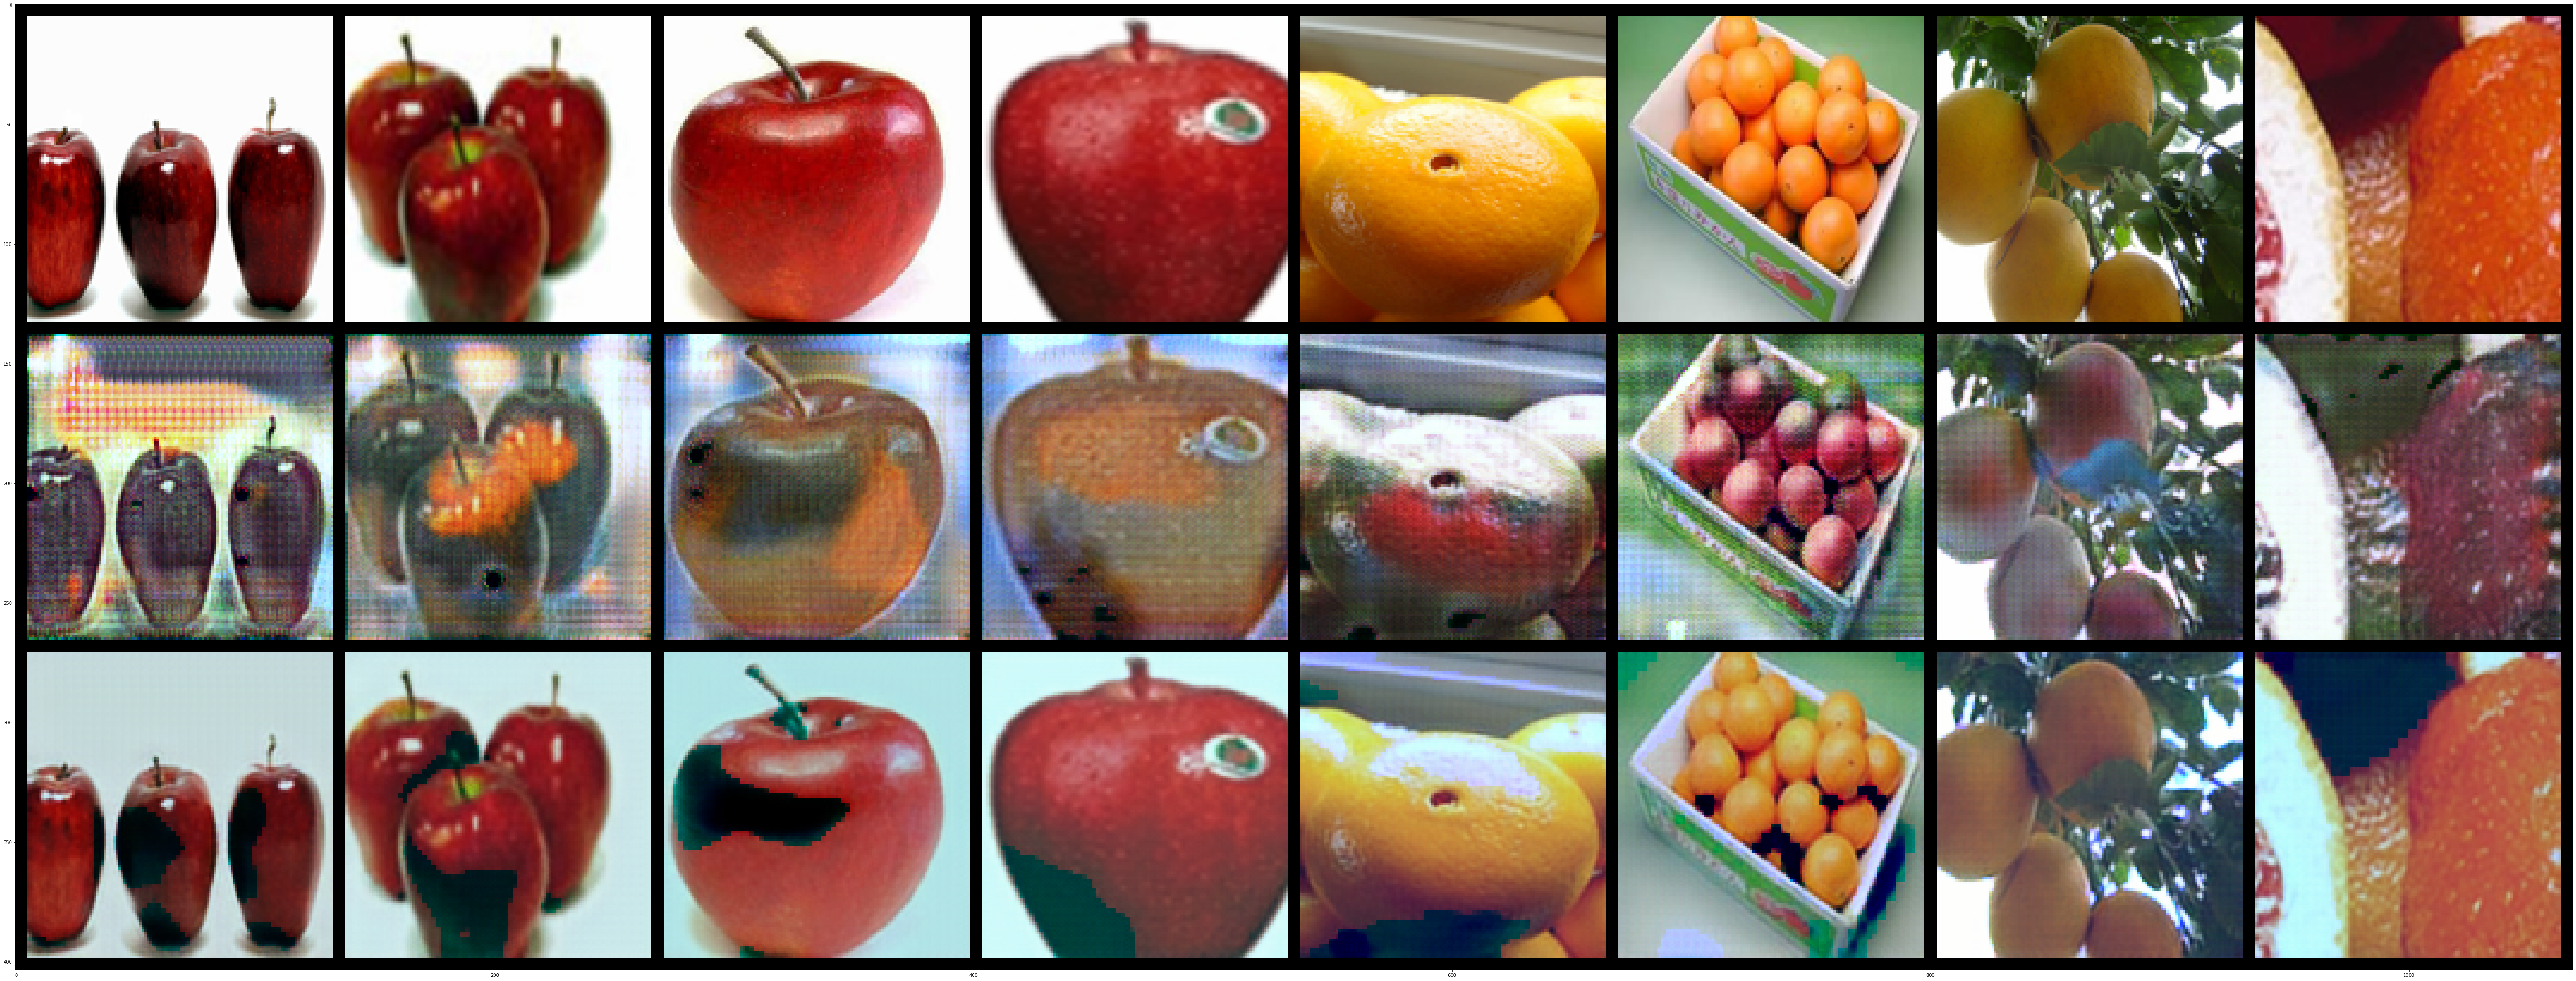

In [11]:
val_dl = DataLoader(AppleOrangeDataset(tfms=tfms, train=False), batch_size=4, shuffle=True)

with t.no_grad():
    a, o = [e.to(device) for e in next(iter(val_dl)).values()]
    gen_a = gen_oa(o)
    gen_o = gen_ao(a)
    id_a = gen_oa(a)
    id_o = gen_ao(o)
imgs = t.cat((a, o, gen_o, gen_a, id_a, id_o))
grid_img = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, padding=5)
plt.figure(figsize=[100, 100])
plt.imshow(grid_img.permute(1, 2, 0).detach().cpu())

### As you can see, some images it does well, but the generator has learned to add greenish colors to the fruits due to what it's learned during training